# [실습4] 자연어 인공지능의 작은 거인 Transformer 구현하기
## 1.  Intro
자연어의 유명하면서도 굉장히 어렵고, 많은 자연어 처리 연구자들이 해결하고자 했던 문제. 바로 변역입니다.   
현재 아직까지도 질 좋은 번역을 얻어보고자 하면, 고학력자의 많은 인력이 반영되어야만 합니다.   
많은 사람들이 다른 나라의 언어를 공부하는 것은 힘들어하지만, 그런 것에 반해, 많은 문화를 누리고, 경험해보고 싶어합니다. 그러다 보니, 많은 자연어 처리 연구진들이 번역이라는 문제를 해결하고 싶어했습니다.   

오늘은 번역이라는 쉽지 않은 주제를 멋지게 풀어낸 트렌스포머라는 모델을 한번 구현하고, 직접 번역문제를 해결해보도록 하겠습니다.

필요한 라이브러리는 다움과 같습니다.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math
import seaborn as sns

from tqdm import tqdm
import matplotlib.pyplot as plt

print(tf.__version__)

2.19.0


## 2. 번역 데이터 준비

In [2]:
# 한국어 압축파일을 압축해제합니다.
!tar -zxvf korean-english-park.dev.tar.gz
!tar -zxvf korean-english-park.test.tar.gz
!tar -zxvf korean-english-park.train.tar.gz


x korean-english-park.dev.en
x korean-english-park.dev.ko
x korean-english-park.test.en
x korean-english-park.test.ko
x korean-english-park.train.en
x korean-english-park.train.ko


가지고 있는 번역 데이터가 어떤지 한 번 열어봅니다.

In [3]:
k_file_path = "korean-english-park.train.ko"
e_file_path = "korean-english-park.train.en"

with open(k_file_path, "r") as f:
    ko_raw = f.read().splitlines()
with open(e_file_path, "r") as f:
    en_raw = f.read().splitlines()

print("Data Size:", len(en_raw))
print("Example:")

for sen in list(zip(en_raw, ko_raw))[0:100][::20]: print(*sen,sep="\n >> ")

Data Size: 94123
Example:
Much of personal computing is about "can you top this?"
 >> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
 >> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
“Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
 >> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
 >> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
 >> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동

#### [TODO] 한글과 영어, 숫자, ?!,.를 제외한 나머지 문자를 제거해봅니다.

In [4]:
# 정규표현식을 활용한 전처리
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'([?!,."])', r' \1 ',sentence) # ?, !, ., , 붙여놓기
    sentence = re.sub(r"[^ㄱ-힣a-zA-Z0-9?!,.\s]", ' ', sentence) #허용문자 지정
    sentence = re.sub(r'[" "]+', ' ',sentence) #공백 정리
    sentence = sentence.strip()
    return sentence


In [5]:
# 데이터 정제
def clean_corpus(kor, eng):
    # 데이터 수가 같은지 확인
    assert len(kor) == len(eng)
    print("데이터 수: ",len(kor))

    dataset = set()
    for i,j in tqdm(list(zip(kor, eng))):
        i = preprocess_sentence(i)
        j = preprocess_sentence(j)
        dataset.add((i,j))
    print(len(dataset))
    cleaned_corpus = list(dataset)
    return cleaned_corpus

In [6]:

cleaned_corpus = clean_corpus(ko_raw, en_raw)

데이터 수:  94123


100%|██████████| 94123/94123 [00:01<00:00, 47561.61it/s]

78934


In [7]:
cleaned_corpus[:5]

[('심슨은 지난 주 라스베이거스 호텔에 침입해 무장강도 행각을 벌인 혐의를 받고 있으며 그 외 추가적으로 10가지 혐의를 받고있다 .',
  'simpson faces 11 charges stemming from an alleged robbery last week in a las vegas hotel .'),
 ('공해상에서 타국의 선박에 탑승하는 것은 불법이다 .',
  'it is illegal to board another country s vessels on the high seas .'),
 ('죽고 싶었던 그는 나중에 처방전 없이 구한 진통제 2병을 삼켰다고 말했다 .',
  'wanting to die , she said she subsequently swallowed two bottles of over the counter pain reliever .'),
 ('엉덩이는 쭉 빼고 이전 보기', 'they have three children'),
 ('아침식사로 야채와 계란이나 고단백질 시리얼 등으로 동물성 단백질를 섭취하고 오전에는 아몬드 10개를 먹는다 . 점심식사는 무가당 요거트 1컵 정도를 먹어서 스태미나를 안정적으로 유지한다 .',
  'eat plant and animal based protein throughout the day an egg or high protein cereal for breakfast , 10 almonds midmorning , a cup of low sugar yogurt in the afternoon and your stamina should stabilize .')]

### 2-1. 토큰화
<hr/>
이제 문장 데이터를 토큰화를 해야 할 차례입니다. Sentencepiece 기반의 토크나이저를 생성해 주는 generate_tokenizer() 함수를 정의합니다.

- [google/sentencepiece](https://github.com/google/sentencepiece)

In [8]:
def generate_tokenizer(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,   # pad token의 일련번호
                       bos_id=1,  # 문장의 시작을 의미하는 bos token(<s>)의 일련번호
                       eos_id=2,  # 문장의 끝을 의미하는 eos token(</s>)의 일련번호
                       unk_id=3,
                       model_type='bpe'):   # unk token의 일련번호
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write(str(row) + '\n')

    import sentencepiece as spm
    spm.SentencePieceTrainer.train(
                input=file, model_prefix=model, vocab_size=vocab_size,
                pad_id=pad_id, bos_id=bos_id, eos_id=eos_id, unk_id=unk_id, model_type=model_type)

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [9]:
kor, eng = zip(*cleaned_corpus)
print(kor[0])
VOCAB_SIZE = 10000
ko_tokenizer = generate_tokenizer(kor,VOCAB_SIZE)
en_tokenizer = generate_tokenizer(eng,VOCAB_SIZE, lang="en")

심슨은 지난 주 라스베이거스 호텔에 침입해 무장강도 행각을 벌인 혐의를 받고 있으며 그 외 추가적으로 10가지 혐의를 받고있다 .


In [10]:
print(eng[0])

simpson faces 11 charges stemming from an alleged robbery last week in a las vegas hotel .


#### [TODO] 저희는 한국어를 맞춰보고 싶으므로 한국어 tokenizer에 시작토큰(bos)과 마지막 토큰(eos)을 추가합니다.

In [11]:
ko_tokenizer.set_encode_extra_options("bos:eos")  # 문장 양 끝에 <s> , </s> 추가

True

토크나이저가 준비되었으니 본격적으로 데이터를 토큰화하도록 하겠습니다. 토큰화를 해주는 함수를 만들어 줍니다.

In [12]:
def make_corpus(sentences, tokenizer):
    corpus = []
    for sentence in tqdm(sentences):
        tokens = tokenizer.encode_as_ids(sentence)
        corpus.append(tokens)
    return corpus


#### [TODO] 우리말과 영어를 각각 토큰화해줍니다. 훈련 데이터를 만들게 됩니다.

In [13]:
ko_corpus = make_corpus(kor, ko_tokenizer)
en_corpus = make_corpus(eng, en_tokenizer)


100%|██████████| 78934/78934 [00:05<00:00, 13517.56it/s]


</div><div class="MarkdownView_markdownView__loFxX"><p>토큰화가 잘 되었는지 확인해 봅시다.</p></div><div id="block-4212d57f-e3ce-4a3c-b96c-857fcd433968-jupyter_block">

In [14]:
print(kor[0])
print(ko_corpus[0])
print('\n')
print(eng[0])
print(en_corpus[0])


심슨은 지난 주 라스베이거스 호텔에 침입해 무장강도 행각을 벌인 혐의를 받고 있으며 그 외 추가적으로 10가지 혐의를 받고있다 .
[1, 289, 1596, 84, 26, 5416, 8776, 1306, 8751, 5904, 8777, 660, 8965, 8785, 224, 6542, 3656, 1522, 711, 561, 12, 192, 924, 210, 215, 1271, 1522, 711, 1204, 4, 2]


simpson faces 11 charges stemming from an alleged robbery last week in a las vegas hotel .
[4826, 3562, 1064, 1684, 3701, 1811, 144, 36, 1603, 7523, 354, 464, 29, 5, 3203, 4568, 2267, 15]


학습데이터를 만들기 위해서는 문장의 길이를 단일화 해주어야합니다. 문장의 길이값을 얼마로 자를지 결정해보도록 하겠습니다.

In [15]:
# 각 문장의 토큰 개수 파악
def num_of_word(corpus):
    length_sen = [0]*len(corpus)
    for i, j in enumerate(corpus):
        length_sen[i] = len(j)
    return length_sen

from collections import Counter
# 문장의 길이별 개수 그래프 생성
def make_graph(length_sen,title=None):
    num_num = Counter(length_sen)
    plt.figure(figsize=(16,10))
    if title:
        plt.title(title)
    plt.bar(range(len(num_num)),[num_num[i] for i in range(len(num_num))],)
    plt.show()

In [90]:
#한글설정
import matplotlib.font_manager as fm

# 직접 설치한 ttf 경로 입력
font_path = r"C:\Users\302-26\AppData\Local\Microsoft\Windows\Fonts\NanumGothic.ttf"  # 예시 (리눅스/Colab 기준)
# 폰트 속성 설정
font_prop = fm.FontProperties(fname=font_path)

# matplotlib에 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

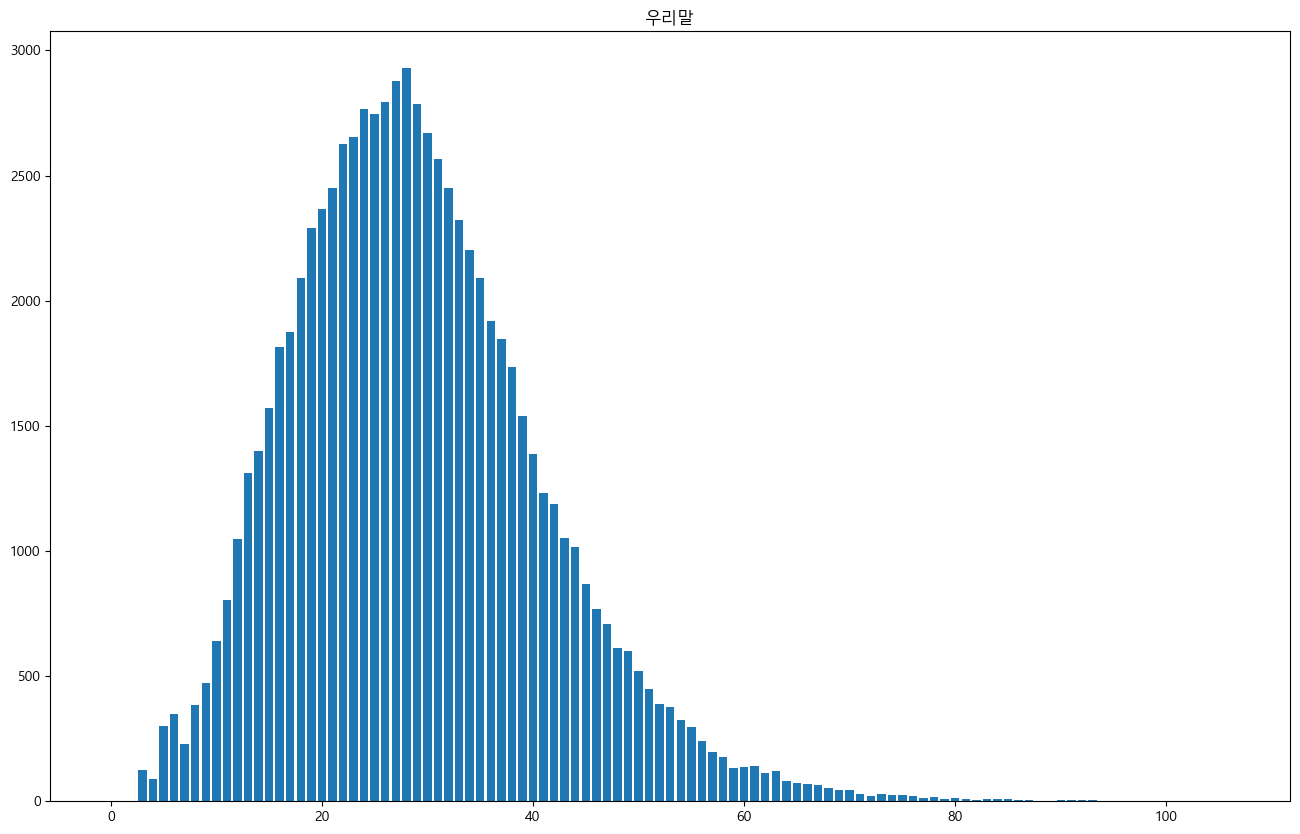

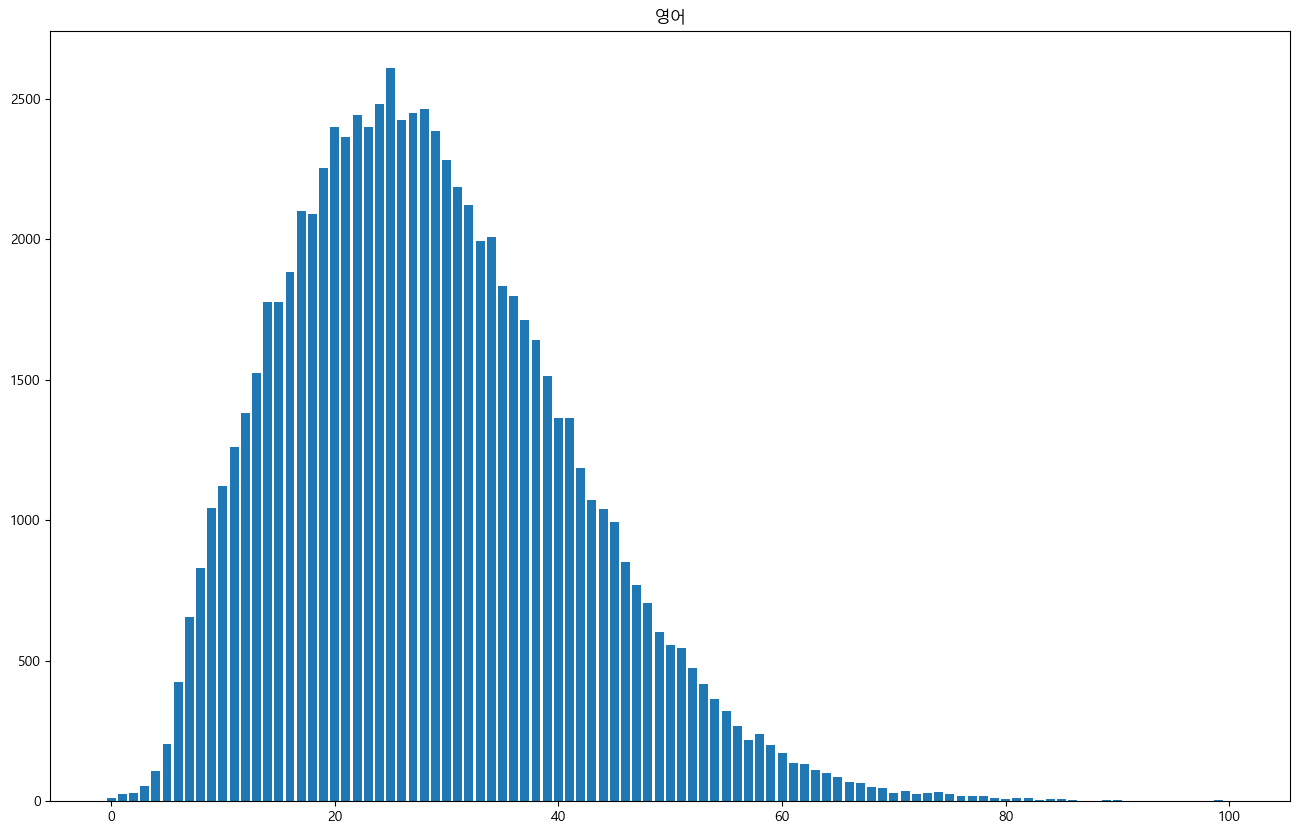

In [91]:
make_graph(num_of_word(ko_corpus),"우리말")
make_graph(num_of_word(en_corpus),"영어")

tensorflow의 pad_sequences 함수를 사용하여, 학습데이터의 문장을 동일화해줍니다.

In [16]:
MAX_LEN = 80
en_ndarray = tf.keras.preprocessing.sequence.pad_sequences(en_corpus, maxlen=MAX_LEN, padding='post',truncating="post")
ko_ndarray = tf.keras.preprocessing.sequence.pad_sequences(ko_corpus, maxlen=MAX_LEN+1, padding='post',truncating="post")

ko_ndarray[:5]

array([[   1,  289, 1596,   84,   26, 5416, 8776, 1306, 8751, 5904, 8777,
         660, 8965, 8785,  224, 6542, 3656, 1522,  711,  561,   12,  192,
         924,  210,  215, 1271, 1522,  711, 1204,    4,    2,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0],
       [   1,   46, 8777, 4669,  259, 1367, 2610, 8751, 1976,   39,  397,
        1227,  134,    4,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

#### [TODO] 동일하게 validation 데이터를 불러와 같은 처리를 진행해 줍니다.

In [17]:
val_k_file_path = "korean-english-park.dev.ko"
val_e_file_path = "korean-english-park.dev.en"

with open(val_k_file_path, "r") as f:
    val_ko_raw = f.read().splitlines()
with open(val_e_file_path, "r") as f:
    val_en_raw = f.read().splitlines()

val_cleaned_corpus = clean_corpus(val_ko_raw, val_en_raw)

데이터 수:  1000


100%|██████████| 1000/1000 [00:00<00:00, 42881.72it/s]

1000


In [18]:
val_kor, val_eng = zip(*val_cleaned_corpus)
val_ko_corpus = make_corpus(val_kor, ko_tokenizer)
val_en_corpus = make_corpus(val_eng, en_tokenizer)

MAX_LEN = 80
val_en_ndarray = tf.keras.preprocessing.sequence.pad_sequences(val_en_corpus, maxlen=MAX_LEN, padding='post',truncating="post")
val_ko_ndarray = tf.keras.preprocessing.sequence.pad_sequences(val_ko_corpus, maxlen=MAX_LEN+1, padding='post',truncating="post")

100%|██████████| 1000/1000 [00:00<00:00, 15099.48it/s]


tensorflow의 from_tensor_slices를 이용하여, Dataset객체를 만들어줍니다.   
해당 객체를 잘 활용하면, 데이터셋을 편하게 다루게 도와줍니다.

In [19]:
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(({'enc_in':en_ndarray, 'dec_in':ko_ndarray[:,:-1]}, ko_ndarray[:,1:])).batch(batch_size=BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(({'enc_in':val_en_ndarray,'dec_in':val_ko_ndarray[:,:-1]}, val_ko_ndarray[:,1:])).batch(batch_size=BATCH_SIZE)

train_dataset


<_BatchDataset element_spec=({'enc_in': TensorSpec(shape=(None, 80), dtype=tf.int32, name=None), 'dec_in': TensorSpec(shape=(None, 80), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 80), dtype=tf.int32, name=None))>

## 3. 트렌스포머 만들기 - 뼈대 구현하기
<hr/>
트랜스포머 구조가 잘 기억나지 않으시거나 구현에 도움이 필요하시면 아래 링크를 참고해 주세요.
<ul>
<li><a href="https://wikidocs.net/31379" target="_blank">위키독스: 트랜스포머</a></li>
<li><a href="https://github.com/google/trax/blob/master/trax/models/transformer.py" target="_blank">Trax: Transformer</a></li>
<li><a href="https://www.tensorflow.org/text/tutorials/transformer" target="_blank">Tensorflow: Transformer</a></li>
</ul>
단, Encoder와 Decoder 각각의 Embedding과 출력층의 Linear, 총 3개의 레이어가 Weight를 공유할 수 있게 하세요.
하이퍼파라미터는 아래와 동일하게 정의합니다.

```python
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)
```

### 3-1. Positional Encoding

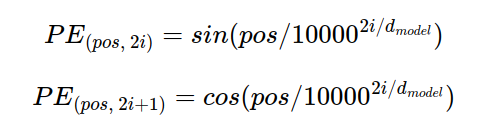

In [20]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    #  코드 구현
    def get_angles(pos, i, d_model):
        return pos / 10000**(2*(i//2)/d_model)

    pos_line = np.arange(pos).reshape(-1,1)
    d_model_line = np.arange(d_model).reshape(1,-1)

    temp_table = get_angles(pos_line, d_model_line, d_model)

    sinusoid_table = np.zeros(temp_table.shape)

    sinusoid_table[:,0::2] = tf.math.cos(temp_table[:,0::2])
    sinusoid_table[:,1::2] = tf.math.sin(temp_table[:,1::2])



    return sinusoid_table

# 원하는 대로 동작하는지 확인해봅니다.
print(positional_encoding(4,5))


[[ 1.          0.          1.          0.          1.        ]
 [ 0.54030231  0.84147098  0.99968454  0.02511622  0.9999998 ]
 [-0.41614684  0.90929743  0.99873835  0.0502166   0.9999992 ]
 [-0.9899925   0.14112001  0.99716204  0.07528529  0.99999821]]


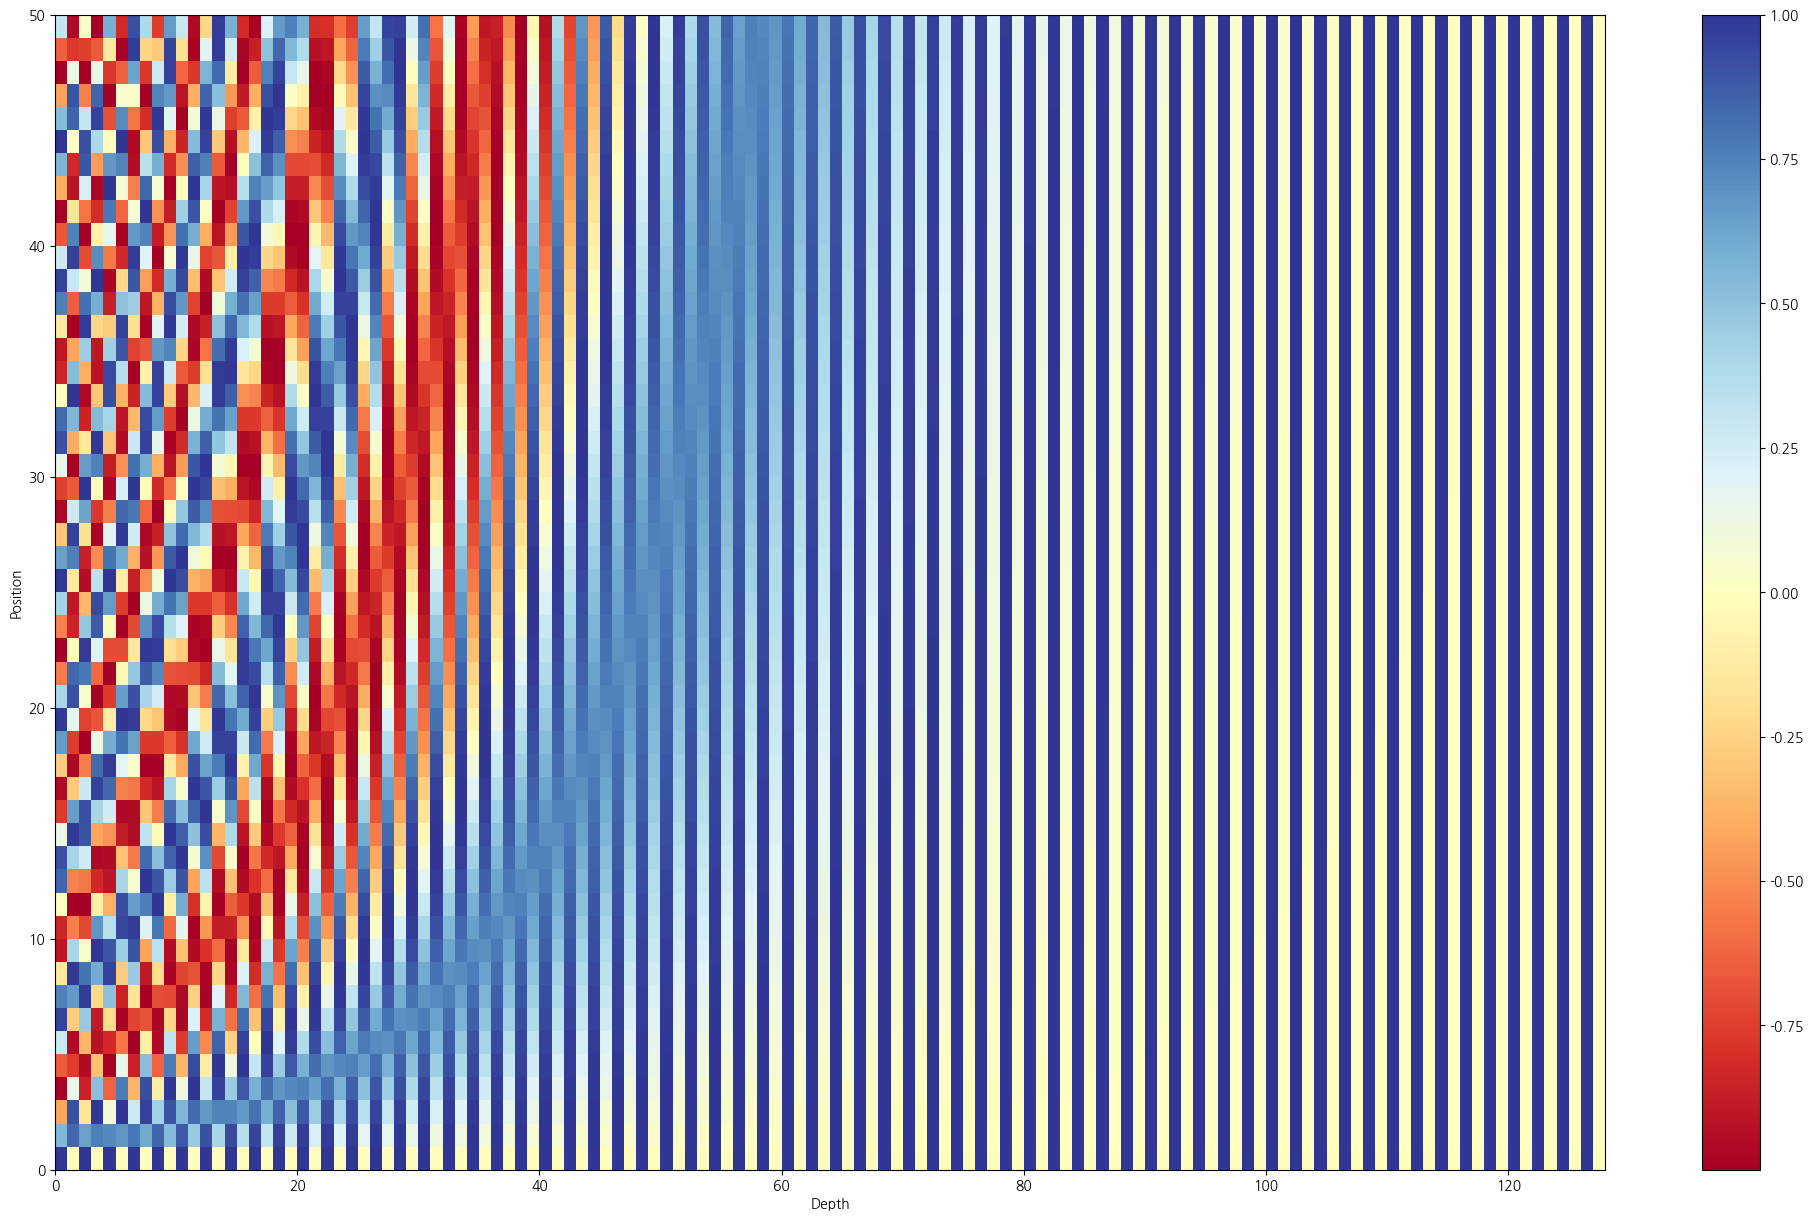

In [98]:
sample_pos_encoding = positional_encoding(50, 128)

plt.figure(figsize=(25,15))
plt.pcolormesh(sample_pos_encoding, cmap='RdYlBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 3-2. mask 만들기

우리가 사용할 Decoder의 데이터는 Mask로 가리워져 있어야 했습니다.   
데이터를 가릴 마스크를 만들며, 트렌스포머를 더 잘 이해해봅시다.   
가릴 부분은 1, 확인할 부분은 0으로 만들도록 하겠습니다.(이유는 뒤에서 확인 가능합니다.)

In [21]:
def generate_padding_mask(seq):
    #  구현
    seq = tf.cast(tf.math.equal(seq,ko_tokenizer.pad_id()),1.0,0.0)
    return seq[:, tf.newaxis, tf.newaxis, :]

디코더에서는 단어를 하나씩 맞출 수 있도록 마스크를 만들어줄 필요가 있습니다.   
그렇게 할 수 있도록 함수 generate_lookahead_mask를 만들어줍니다.   
아래 코드를 참고하세요.

In [22]:
np.ones((10,10))
1 - tf.linalg.band_part(np.ones((5,5)),-1,0)

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])>

In [23]:
def generate_lookahead_mask(size):
    #  구현
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)),-1,0)
    return mask

#### [TODO] encoder와 decoder가 사용할 마스크를 만들어줍니다. 만든 모든 마스크를 return으로 반환합니다.

In [30]:
# Mask  생성하기
def generate_masks(src, tgt):
    #  구현
    enc_mask = generate_padding_mask(src)
    dec_enc_mask = generate_padding_mask(src)
    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])
    dec_mask = tf.maximum(dec_lookahead_mask,generate_padding_mask(tgt))
    return enc_mask, dec_enc_mask, dec_mask

상당히 어렵게 생긴 마스크들을 만들었는데, 원하는 데로 잘 동작하는지 작동시켜봅니다.

In [31]:
# 데이터셋에서 1개 배치만 가져옵니다.
for i in train_dataset: break
i

({'enc_in': <tf.Tensor: shape=(256, 80), dtype=int32, numpy=
  array([[4826, 3562, 1064, ...,    0,    0,    0],
         [  90,   81, 2652, ...,    0,    0,    0],
         [ 864,   32,   33, ...,    0,    0,    0],
         ...,
         [ 744,   73,   56, ...,    0,    0,    0],
         [3393,   49, 6981, ...,    0,    0,    0],
         [ 291, 1566, 1186, ...,    0,    0,    0]])>,
  'dec_in': <tf.Tensor: shape=(256, 80), dtype=int32, numpy=
  array([[   1,  289, 1596, ...,    0,    0,    0],
         [   1,   46, 8777, ...,    0,    0,    0],
         [   1,  903, 8755, ...,    0,    0,    0],
         ...,
         [   1, 8562, 9219, ...,    0,    0,    0],
         [   1, 5358, 4380, ...,    0,    0,    0],
         [   1, 3167, 8753, ...,    0,    0,    0]])>},
 <tf.Tensor: shape=(256, 80), dtype=int32, numpy=
 array([[ 289, 1596,   84, ...,    0,    0,    0],
        [  46, 8777, 4669, ...,    0,    0,    0],
        [ 903, 8755, 1143, ...,    0,    0,    0],
        ...,
   

In [32]:
# Encoder와 Decoder의 Tensor를 한번에 만들어줍니다.
generate_masks(i[0]['enc_in'],i[1])

(<tf.Tensor: shape=(256, 1, 1, 80), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(256, 1, 1, 80), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        ...,
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]],
 
 
        [[[0., 0., 0., ..., 1., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(256, 1, 80, 80), dtype=float32, numpy=
 array([[[[0., 1., 1., ..., 1., 1., 1.],
          [0., 0., 1., ..., 1., 1., 1.],
          [0., 0., 0., ..., 1., 1., 1.],
          ...,
          [0., 0., 0., ..., 1., 1., 1.],
          [0., 0., 0

마스크는 어떻게 생긴걸까요? 확인해보도록 하겠습니다.

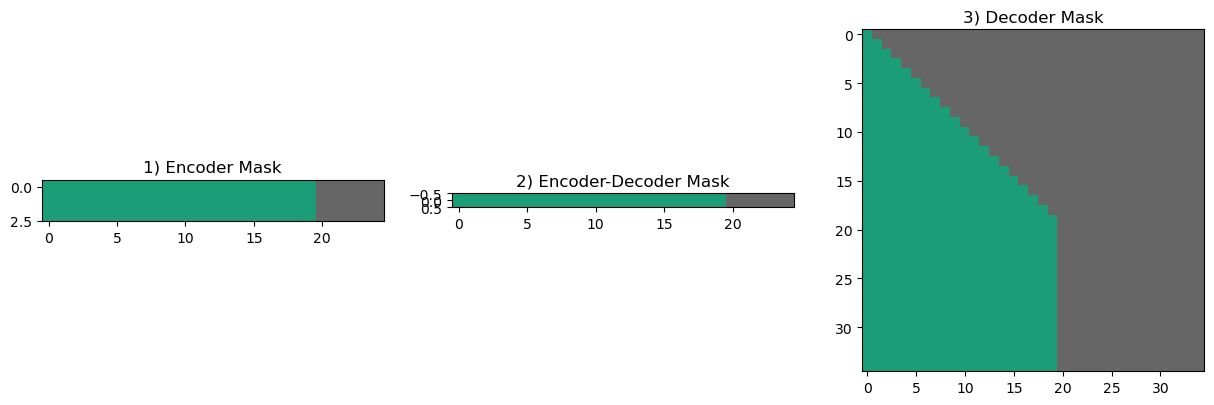

In [33]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(15, 15))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

해당 마스크는 Transformer의 학습에 매우 중요한 역할을 담당합니다. 학습을 함에 있어, Attention 알고리즘을 문장에서 어디부분을 확인해야하는지 찾아보는 역할을 담당하는데, 마스크는 Attention이 볼 부분과, 보지 않을 부분을 구분해줍니다. 여기서 숫자 1부분이 마스크 역할을 담당하며, 마스크를 씌우는 연산을 거친 후 softmax를 취할 때, 해당 값의 확률을 0으로 만들어주는 역할을 합니다.(문장에서 빈 부분은 보지 않겠다는 의미를 갖습니다.) 여기서 Decoder의 mask는 왜 이렇게 생겼을까요? 바로 단어를 하나하나 예측해볼 수 있도록, 한 단어씩 넘기며, 다음 단어를 예측할 수 있도록 마스크를 만들어주어야 하기 때문입니다. 때문에 토큰 35길이의 문장이었다면, 한 단어 씩 가려, 35번 학습을 진행할 수 있도록 계단식 마스크를 만들어 씌어주게 되는 것입니다. 아래의 코드로 더 구체적인 원리를 확인해봅시다!

### 3-3. Multi Head Attention 구현

Encoder와 Decoder에서 모두 사용할 수 있게 Multi Head Attention를 구현해봅니다.

In [34]:
# Multi Head Attention 구현
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = tf.cast(num_heads,tf.float32)
        self.d_model = tf.cast(d_model,tf.float32)

        self.depth = tf.cast(d_model // self.num_heads,tf.float32)

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        #  구현완료
        matmul_qk = tf.matmul(Q,K,transpose_b=True)
        matmul_qk = matmul_qk / tf.math.sqrt(self.depth)

        if mask is not None:
            matmul_qk += mask*(-1e9)

        attention_score = tf.keras.activations.softmax(matmul_qk,axis=-1)
        out = tf.matmul(attention_score, V)

        return out, attention_score

    def split_heads(self, x):
        #  구현
        split_x = tf.reshape(x,(-1,x.shape[1],self.num_heads,self.depth))

        return tf.transpose(split_x,(0,2,1,3)) # (batch_size, num_head, sen_len, depth)

    def combine_heads(self, x):
        #  구현
        combined_x = tf.transpose(x,(0,2,1,3))
        return tf.reshape(combined_x,(-1,x.shape[2],self.d_model))

    def call(self, x, mask):
        #  구현
        if type(x) is list:
            Q = self.W_q(x[0])
            K = self.W_k(x[1])
            V = self.W_v(x[2])
        else:
            Q = self.W_q(x)
            K = self.W_k(x)
            V = self.W_v(x)
        split_Q = self.split_heads(Q)
        split_K = self.split_heads(K)
        split_V = self.split_heads(V)

        out, attention_weights = self.scaled_dot_product_attention(split_Q, split_K, split_V,mask)

        out = self.combine_heads(out)

        return out, attention_weights

### 3-4. Position-wise Feed Forward Network

단어의 특성을 만들어주는 Position-wise Feed Forward Network를 구현해봅니다.    
아래의 식을 참고해보셔도 좋습니다.

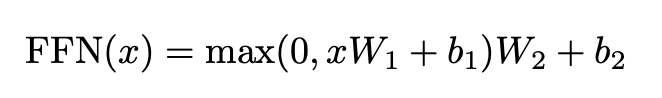


In [35]:
# Position-wise Feed Forward Network 구현
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        #  구현
        out = self.fc1(x)  # -> 2048
        out = self.fc2(out) # -> 512

        return out

### 3-5. EncoderLayer, DecoderLayer의 구현
이제 준비물이 만들어졌으니, 해당 도구들을 이용하여, EncoderLayer, DecoderLayer를 만들어보도록 하겠습니다!

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.drop = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        '''
        Multi-Head Attention
        '''
        out, enc_attn = self.enc_self_attn(x,mask)
        out = self.drop(out)
        x = self.norm_1(out+x) # residual + layerNormalization

        '''
        Position-Wise Feed Forward Network
        '''
        out = self.ffn(x)
        out = self.drop(out) # dropout은 학습되는 층이 아니기 때문에 공유해서 사용합니다.
        out = self.norm_2(out+x)

        return out, enc_attn

tf.keras.layers.Layer 를 상속받아 직접 만든 Layer, 과연 잘 동작할까요?   
한번 tensor를 통과시켜보도록 하겠습니다.

In [37]:
encoderlayer = EncoderLayer(512,8,2048,0.4)

input_tensor_test = np.ones((16,50,512),dtype=np.float32)

mask = generate_padding_mask(np.ones((16,50),dtype=np.float32))

enc_out, attn = encoderlayer(input_tensor_test, mask)
enc_out[0], attn[0]

c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_head_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


(<tf.Tensor: shape=(50, 512), dtype=float32, numpy=
 array([[ 0.6140032 ,  0.19389656, -0.36882606, ..., -0.93583184,
          0.21833977,  1.4676454 ],
        [ 0.6140032 ,  0.19389656, -0.36882606, ..., -0.93583184,
          0.21833977,  1.4676454 ],
        [ 0.6140032 ,  0.19389656, -0.36882606, ..., -0.93583184,
          0.21833977,  1.4676454 ],
        ...,
        [ 0.6140032 ,  0.19389656, -0.36882606, ..., -0.93583184,
          0.21833977,  1.4676454 ],
        [ 0.614003  ,  0.1938965 , -0.36882532, ..., -0.93583226,
          0.21833934,  1.4676462 ],
        [ 0.614003  ,  0.1938965 , -0.36882532, ..., -0.93583226,
          0.21833934,  1.4676462 ]], dtype=float32)>,
 <tf.Tensor: shape=(8, 50, 50), dtype=float32, numpy=
 array([[[0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
         [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
         [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
         ...,
         [0.02, 0.02, 0.02, ..., 0.02, 0.02, 0.02],
         [0.02, 0.02, 0.02, .

위의 Encoder layer를 참고하여, Decoder layer도 만들어 보도록 하겠습니다.   
잘 기억이 안나면, 해당 내용을 참고하셔도 좋습니다.   
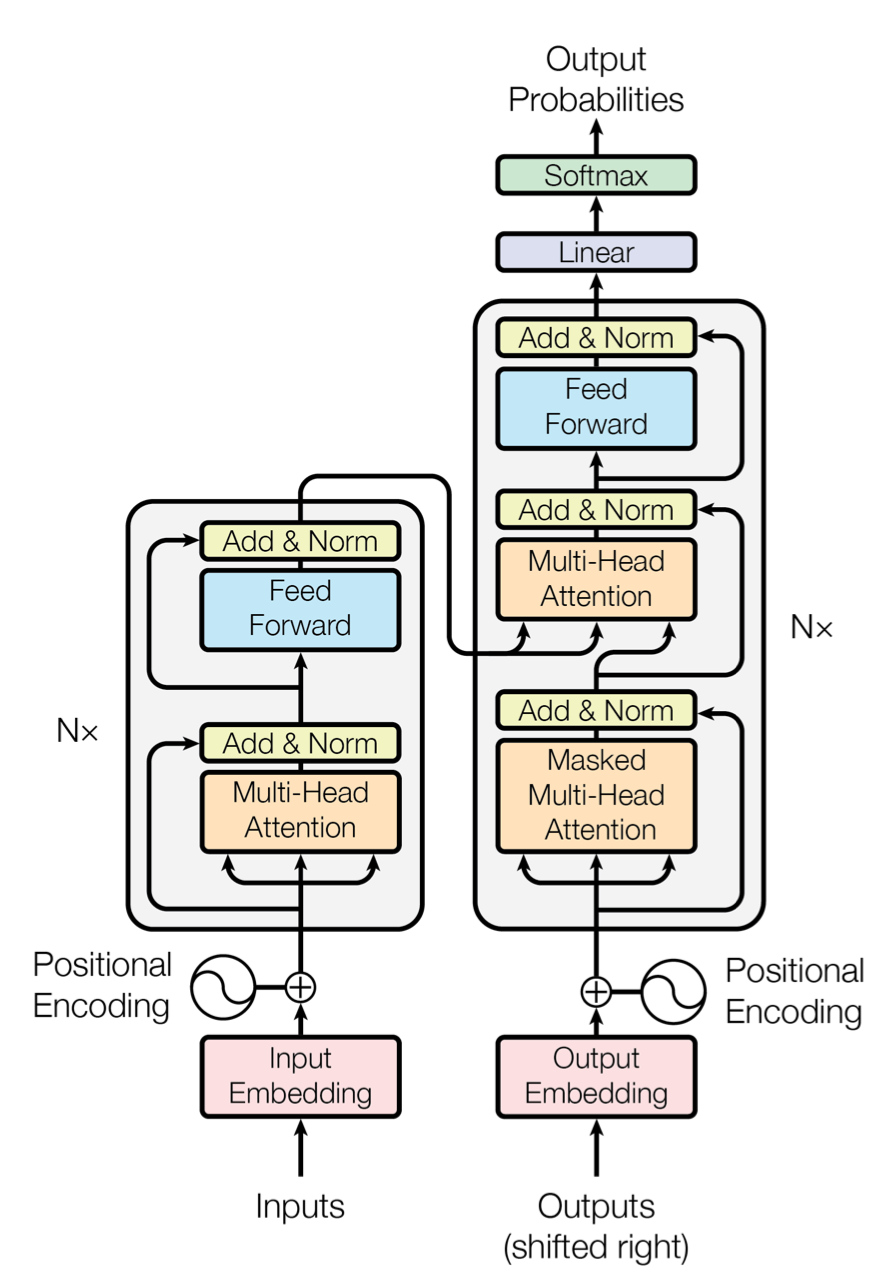


In [38]:
# Decoder 레이어 구현
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, dec_enc_mask, dec_mask):

        '''
        Masked Multi-Head Attention
        '''
        #  구현
        out, dec_attn = self.dec_self_attn(x,dec_mask)
        out = self.do(out)
        x = self.norm_1(out+x)

        '''
        Multi-Head Attention
        '''
        #  구현
        out, dec_enc_attn = self.enc_dec_attn([x,enc_out,enc_out],dec_enc_mask)
        out = self.do(out)
        x = self.norm_2(out + x)

        '''
        Position-Wise Feed Forward Network
        '''
        #  구현
        out = self.ffn(x)
        out = self.do(out)
        out = self.norm_3(out + x)

        return out, dec_attn, dec_enc_attn

마찬가지로 잘 구현이 되었다면 아래의 텐서를 통과시켰을 때, 잘 동작할 것입니다!

In [39]:
decoderlayer = DecoderLayer(512,8,2048,0.4)

tgt_tensor_test = np.ones((16,50,512),dtype=np.float32)

enc_mask, dec_enc_mask, dec_mask = generate_masks(np.ones((16,50),dtype=np.float32),np.ones((16,50),dtype=np.float32))

dec_out, dec_attn, dec_enc_attn = decoderlayer(tgt_tensor_test, enc_out, dec_enc_mask, dec_mask)
dec_out[0]


c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_head_attention_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_head_attention_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<tf.Tensor: shape=(50, 512), dtype=float32, numpy=
array([[ 0.70560634, -1.4862567 ,  2.0772486 , ...,  0.46631873,
         1.7556535 ,  0.5575996 ],
       [ 0.70560634, -1.4862567 ,  2.0772486 , ...,  0.46631873,
         1.7556535 ,  0.5575996 ],
       [ 0.7056064 , -1.4862568 ,  2.0772486 , ...,  0.46631888,
         1.7556536 ,  0.55759954],
       ...,
       [ 0.7056067 , -1.4862573 ,  2.0772486 , ...,  0.46631888,
         1.7556531 ,  0.5575998 ],
       [ 0.7056065 , -1.486257  ,  2.0772488 , ...,  0.46631852,
         1.7556536 ,  0.5576004 ],
       [ 0.70560634, -1.4862567 ,  2.0772483 , ...,  0.4663186 ,
         1.7556535 ,  0.55760014]], dtype=float32)>

## 4. 트렌스포머 만들기 - 본체 만들기

이제 트렌스포머를 만들 본격적인 준비가 모두 되었습니다.   
직접 하나하나 내용을 만들어보는 뜻깊은 실습입니다.   


### 4-1. Encoder 만들기

In [40]:
# Encoder 구현
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout)
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        #  구현
        out = x
        for enc_layer in self.enc_layers:
            out, enc_attns = enc_layer(out,mask)


        return out, enc_attns

### 4-2. Decoder 만들기

#### [TODO] call method에 데이터의 흐름을 올바르게 만들어봅니다.

In [41]:
# Decoder 구현
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout)
                            for _ in range(n_layers)]


    def call(self, x, enc_out, dec_enc_mask, dec_mask):
        out = x
        dec_attns = []
        dec_enc_attns = []
        for dec_layer in self.dec_layers:
            out, dec_attn, dec_enc_attn = dec_layer(out, enc_out, dec_enc_mask, dec_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

Encoder와 Decoder가 우리가 원하는 대로 동작하는지 확인해보겠습니다.

In [42]:
n_layers = 2
n_heads = 8
d_model = 512
d_ff = 1024
dropout= 0.4

encoder = Encoder(n_layers=n_layers,
                  n_heads = n_heads,
                  d_model=d_model,
                  d_ff=d_ff,
                  dropout=dropout)
decoder = Decoder(n_layers=n_layers,
                  n_heads = n_heads,
                  d_model=d_model,
                  d_ff=d_ff,
                  dropout=dropout)

input_test = np.ones((16,50,512),dtype=np.float32)

tgt_test = np.ones((16,50,512),dtype=np.float32)

enc_mask, dec_enc_mask, dec_mask = generate_masks(np.ones((16,50),dtype=np.float32),np.ones((16,50),dtype=np.float32))

enc_out, enc_attns = encoder(input_test,enc_mask)

dec_out, dec_attns, dec_enc_attns = decoder(tgt_test,enc_out,dec_enc_mask, dec_mask)


c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_head_attention_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_head_attention_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_h

In [43]:
dec_out[0]

<tf.Tensor: shape=(50, 512), dtype=float32, numpy=
array([[ 1.749714  , -1.6821029 , -0.26490915, ..., -0.0478842 ,
        -0.79799885,  0.463155  ],
       [ 1.749714  , -1.6821029 , -0.26490915, ..., -0.0478842 ,
        -0.79799885,  0.463155  ],
       [ 1.7497143 , -1.6821032 , -0.26490882, ..., -0.04788437,
        -0.79799885,  0.4631547 ],
       ...,
       [ 1.7497143 , -1.6821028 , -0.26490876, ..., -0.04788417,
        -0.7979991 ,  0.463155  ],
       [ 1.7497144 , -1.6821029 , -0.26490855, ..., -0.04788402,
        -0.79799855,  0.46315446],
       [ 1.7497141 , -1.6821028 , -0.2649086 , ..., -0.04788414,
        -0.7979986 ,  0.46315452]], dtype=float32)>

```text
<tf.Tensor: shape=(50, 512), dtype=float32, numpy=
array([[-3.0628598 ,  1.5535934 ,  0.78368604, ...,  1.8038454 ,
         1.1531229 , -0.08711738],
       [-3.0628598 ,  1.5535934 ,  0.78368604, ...,  1.8038454 ,
         1.1531229 , -0.08711738],
       [-3.0628593 ,  1.5535938 ,  0.78368586, ...,  1.8038452 ,
         1.1531235 , -0.08711717],
       ...,
       [-3.0628598 ,  1.5535935 ,  0.783686  , ...,  1.8038454 ,
         1.1531235 , -0.08711694],
       [-3.06286   ,  1.5535938 ,  0.78368574, ...,  1.8038454 ,
         1.1531233 , -0.08711688],
       [-3.0628595 ,  1.5535935 ,  0.78368604, ...,  1.8038456 ,
         1.153124  , -0.08711685]], dtype=float32)>
```
이런 모습의 output이 나오면 완성입니다.

### 4-3. Transformer 전체 모델 조립

In [44]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 src_vocab_size,
                 tgt_vocab_size,
                 pos_len,
                 dropout=0.2,
                 shared_fc=True,
                 shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        self.train = True

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    # embedding, call 구현하기
    def embedding(self, emb, x):
        #  구현
        out = emb(x) + self.pos_encoding[:x.shape[1]]
        return out

    # 모델 학습 속도, 메모리를 최적화 시키기 위해 tf.tunction()사용
    @tf.function()
    def call(self, x):
        #  구현
        enc_in, dec_in = x['enc_in'],x['dec_in']
        enc_mask, dec_enc_mask, dec_mask = generate_masks(enc_in, dec_in)
        inp_tensor = self.do(self.embedding(self.enc_emb, enc_in))
        tgt_tensor = self.do(self.embedding(self.dec_emb, dec_in))
        enc_out, enc_attns = self.encoder(inp_tensor,enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(tgt_tensor,enc_out,dec_enc_mask,dec_mask)
        logits = self.fc(dec_out)
        if self.train:
            return logits
        else: return logits, enc_attns, dec_attns, dec_enc_attns

    def train(self):
        self.train = True

    def eval(self):
        self.train = False

In [45]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
n_layers = 2
n_heads = 4
d_model = 128
d_ff = 1024
dropout= 0.4
src_vocab_size = 10000
tgt_vocab_size = 10000
pos_len = 100
shared_fc = True
shared_emb = False

model = Transformer(n_layers=n_layers,
                    n_heads=n_heads,
                    d_model=d_model,
                    d_ff=d_ff,
                    dropout=dropout,
                    src_vocab_size=src_vocab_size,
                    tgt_vocab_size=tgt_vocab_size,
                    pos_len=pos_len,
                    shared_fc=shared_fc,
                    shared_emb=shared_emb)
test_data = {'enc_in':np.zeros((16,40),dtype=np.float32), 'dec_in':np.zeros((16,40),dtype=np.float32)}
model(test_data)
model.summary()

c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_head_attention_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_head_attention_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\302-26\anaconda3\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'multi_

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (16, 40, 128)          │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (16, 40, 128)          │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Encoder)             │ ?                      │       626,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Decoder)             │ ?                      │       726,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (16, 40, 10000)        │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,202,960 (19.85 MB)

 Trainable params: 5,202,960 (19.85 MB)

 Non-trainable params: 0 (0.00 B)

## 5. 모델 학습하기

모델도 만들었고, 데이터도 준비가 되었으니, 드디어 학습을 할 시간입니다!   
바로 fit을 하면 될까요?
아직 조금 할 일이 남았습니다.

### 5-1. LearningRateScheduler
optimizer도 만들어야하고, transformer는 큰 모델이기 때문에 좋은 학습을 위해서는 더 다양한 작업이 필요합니다.   
그중 하나가 바로 LearningRateScheduler! learning rate를 학습 도중에 수정해주면서 학습을 진행하겠습니다.

In [46]:
# Learning Rate Scheduler 구현
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        #  구현
        step = tf.cast(step,tf.float32)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

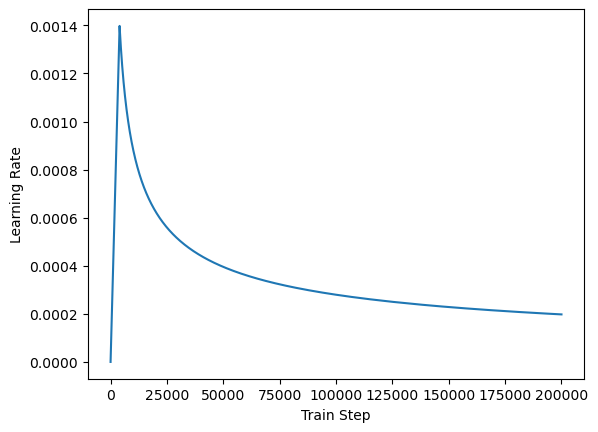

In [47]:
sample_learning_rate = LearningRateScheduler(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 5-2. optimizers
LearningRateScheduler를 담은 optimizers를 만들어주겠습니다!   
optimizers종류는 논문에서 나온대로 Adam을 사용하도록 하겠습니다.

In [48]:
# Learning Rate 인스턴스 선언 & Optimizer 구현

learning_rate_scheduler = LearningRateScheduler(d_model=d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)


### 5-3. loss function

이제 모델을 학습할 메트릭을 제시해야합니다.   
3,76,145 이런식으로 정답의 라벨이 숫자로 되어있는경우 우리는 tf.keras.losses.SparseCategoricalCrossentropy를 사용해볼 수 있습니다.   

In [49]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    #  구현 # real: (16,50), pred:(16,50,20000)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(real, pred)

    mask = tf.cast(tf.not_equal(real, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

모델과 optimizer, loss_function을 결합해줍니다. 모델의 학습에 함께 동작하게 됩니다.

In [50]:
model.compile(optimizer=optimizer,loss=loss_function)

이제 인공지능 번역기를 학습시킬 준비가 끝났습니다. 한번 학습시켜 보도록 하겠습니다.   
조금 시간이 걸립니다.(약 30 ~ 60분: GPU성능에 따라) 잠시 커피라도 한잔 하는 것도 좋겠습니다.

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_transformer2.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

epochs = 10
model.fit(train_dataset,validation_data=val_dataset,epochs=epochs, callbacks=[checkpoint])

Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 3.1716
Epoch 1: val_loss improved from inf to 2.95188, saving model to best_transformer2.weights.h5
309/309 ━━━━━━━━━━━━━━━━━━━━ 1288s 4s/step - loss: 3.1712 - val_loss: 2.9519
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.7812
Epoch 2: val_loss improved from 2.95188 to 2.71035, saving model to best_transformer2.weights.h5
309/309 ━━━━━━━━━━━━━━━━━━━━ 1226s 4s/step - loss: 2.7810 - val_loss: 2.7104
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.5411
Epoch 3: val_loss improved from 2.71035 to 2.45141, saving model to best_transformer2.weights.h5
309/309 ━━━━━━━━━━━━━━━━━━━━ 1246s 4s/step - loss: 2.5409 - val_loss: 2.4514
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 2.3175
Epoch 4: val_loss improved from 2.45141 to 2.29826, saving model to best_transformer2.weights.h5
309/309 ━━━━━━━━━━━━━━━━━━━━ 1182s 4s/step - loss: 2.3174 - val_loss: 2.2983
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 4

loss가 적절하게 떨어지고 있는 것으로 보입니다. 그러면 정말로 번역을 할 수 있는 것인지 확인해보도록 하겠습니다.

## 6. 모델 성능 확인하기

다음 단어를 한 단어 한 단어 예측하여, 번역을 해주는 함수를 만들어 봅니다.

### 6-1. 어텐션 시각화 함수
우리가 진행하는 어텐션 알고리즘은 잘 이루어지고 있는 것일까요? 시각화 함수를 만들어봅니다.

In [70]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns, num_head=None):
    def draw(data, ax, x="auto", y="auto"):
        sns.heatmap(data,
                    square=True,
                    vmin=0.0, vmax=1.0,
                    cbar=False, ax=ax,
                    xticklabels=x,
                    yticklabels=y)

    # Convert to numpy arrays
    enc_attns = np.array(enc_attns)
    dec_attns = np.array(dec_attns)
    dec_enc_attns = np.array(dec_enc_attns)

    # Handle attention shape: [layers, heads, tgt, src] or [1, heads, tgt, src]
    enc_attns = enc_attns[0] if enc_attns.ndim == 4 else enc_attns[0, 0]
    dec_attns = dec_attns[0] if dec_attns.ndim == 4 else dec_attns[0, 0]
    dec_enc_attns = dec_enc_attns[0] if dec_enc_attns.ndim == 4 else dec_enc_attns[0, 0]

    # Automatically detect or set number of heads
    n_heads = enc_attns.shape[0] if num_head is None else min(num_head, enc_attns.shape[0])

    # Encoder Self Attention
    fig, axs = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
    print("Encoder Self-Attention")
    for h in range(n_heads):
        draw(enc_attns[h, :len(src), :len(src)], axs[h], src, src)
    plt.show()

    # Decoder Self Attention
    fig, axs = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
    print("Decoder Self-Attention")
    for h in range(n_heads):
        draw(dec_attns[h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
    plt.show()

    # Encoder-Decoder Cross Attention
    fig, axs = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
    print("Cross Attention (Decoder → Encoder)")
    for h in range(n_heads):
        draw(dec_enc_attns[h, :len(tgt), :len(src)], axs[h], src, tgt)
    plt.show()

해당 함수를 사용하려면, 번역된 결과가 있어야 하겠습니다. 이어서 번역문을 만들 수 있는 함수를 구현해보겠습니다.

### 6-2. 번역문 만들기

이제 번역문을 만드는 함수를 만들어보겠습니다.   
단순히 input token을 받아, decoder에서 output token을 받고, 총 결과를 한글로 decode합니다.

In [71]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer, max_len=100):
    model.eval()
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=MAX_LEN,
                                                           padding='post',
                                                           truncating="post")

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(max_len):
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(
            {"enc_in":_input,
             "dec_in":output}
            )

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns


#### [TODO] 이렇게 만들어진 함수들을 결합시켜, 보다 편하게 쓸 수 있도록 만들어봅니다. plot_attention=False 옵션을 주어, 원할 때만 그래프가 나오도록 해봅니다.

In [72]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence)) # %표기법
    print('Predicted translation: {}'.format(result)) # {} .format 표기법

    if plot_attention:
        visualize_attention(pieces, tgt_tokenizer.EncodeAsPieces(result), enc_attns, dec_attns, dec_enc_attns)

    return result

한번 사용해보도록 하겠습니다.

In [57]:
translate("I love you so much.", model, en_tokenizer, ko_tokenizer)

Input: I love you so much.
Predicted translation: 나는 나는 내 인생에 대해 사랑한다 .


'나는 나는 내 인생에 대해 사랑한다 .'

어떻게 해당 단어들을 예측하고 있는 것인지도 같이 출력해봅니다.

Input: I love you so much.
Predicted translation: 나는 나는 내 인생에 대해 사랑한다 .
Encoder Self-Attention


c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


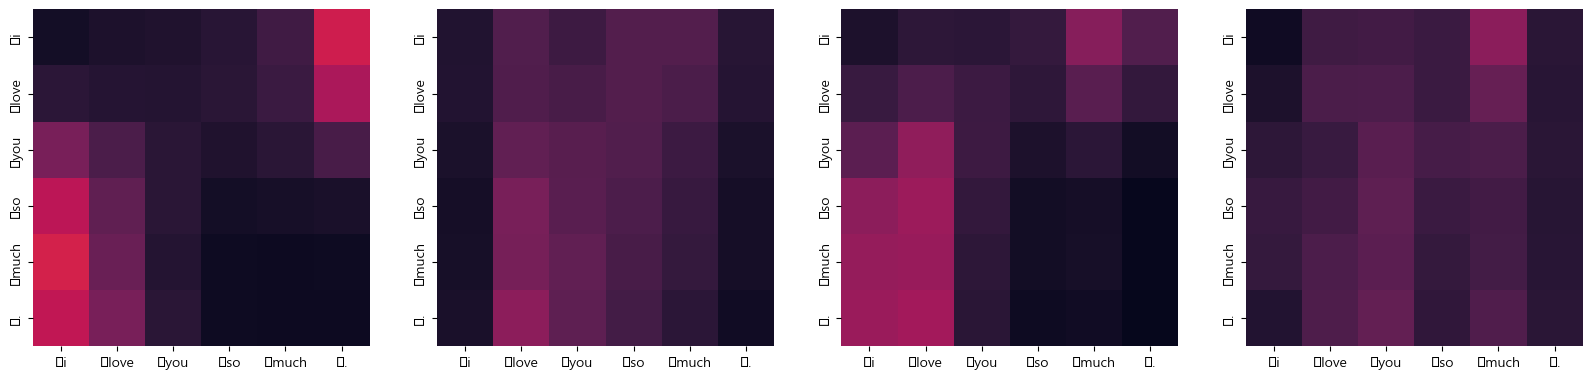

Decoder Self-Attention


c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


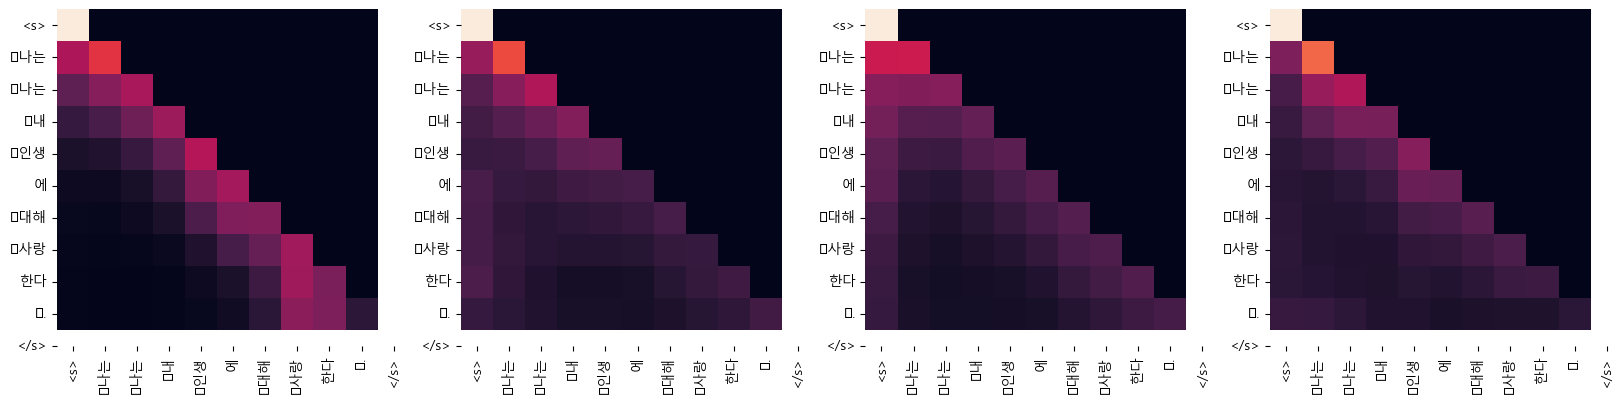

Cross Attention (Decoder → Encoder)


c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\Users\302-26\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


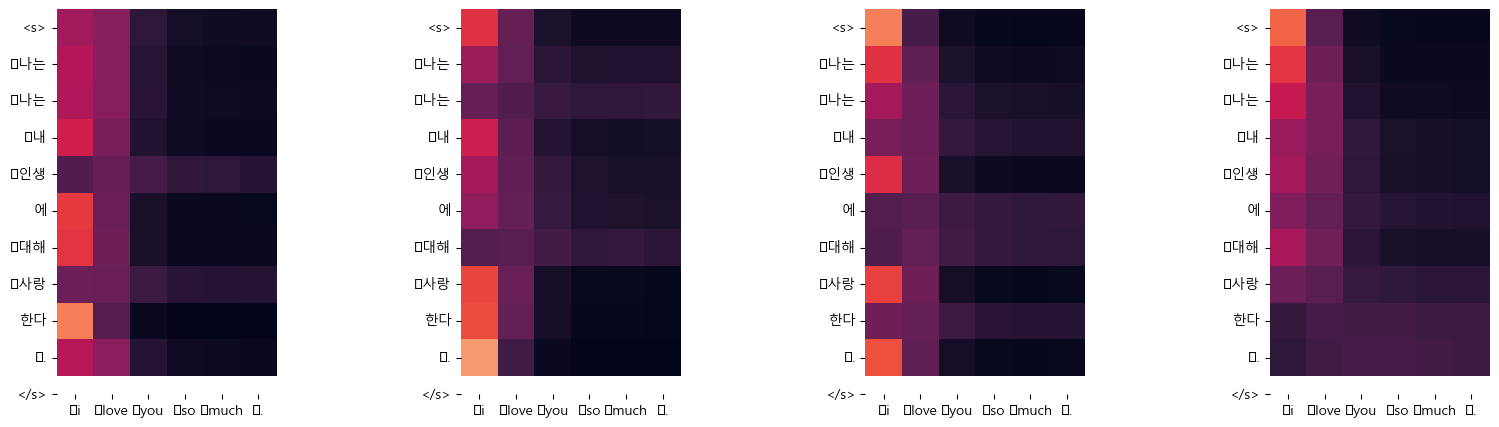

'나는 나는 내 인생에 대해 사랑한다 .'

In [92]:
translate("I love you so much.", model, en_tokenizer, ko_tokenizer, plot_attention=True)

자연어 인공지능의 하나의 큰 획, Transformer에 대해 살펴봤습니다. 이 엄청난 원리로 현재 모든 언어모델이 만들어지고 있다고 해도 과언이 아닙니다.   
자연어의 세계로 더 깊이 빠져봅시다!

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright 2023. Elice Inc. all rights reserved.</span>